In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
import numpy as np

In [87]:
import os
import time
from matplotlib import colors as clrs
from matplotlib import cm as cm
from detect_peaks import detect_peaks as dp
from detect_peaks import _plot as dpp

Generic method to smooth a data set adapted from the scipy cookbook
window_type can be adjusted to use alternate pre-defined window functions

In [14]:
def smooth(inpt, window_len=10, window_type='flat'):
    if not (window_len % 2 == 0):
        window_len += 1
        print('Window length supplied is odd - using next highest integer: {}.'.format(window_len))
        
    if window_len <= 3:
        print('Error in data smoothing - please select a larger window length')
        return None
    
    if not window_type in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        print('Error - Invalid window_type')
        return None
    
    s = np.r_[inpt[window_len-1:0:-1], inpt, inpt[-1:-window_len:-1]]
    if window_type == 'flat':  # moving average
        w = np.ones(window_len, 'd')
    else:
        w = eval('np.'+window_type+'(window_len)')
    otpt = np.convolve(w/w.sum(), s, mode='valid')
    return otpt[int(window_len/2 -1):-int(window_len/2)]

Get a List of data files from a given data directory

In [15]:
data_path = "/Users/Maxwell/Desktop/Ru_UNH_LEEM/141020/141020_03_LEEM-IV_50FOV/"
files = [name for name in os.listdir(data_path) if name.endswith('.dat')]

Parameters to set the correct energy range for a given LEEM data set

In [16]:
starte = -9.9

In [17]:
stepe = 0.1

Populate the energy list to match the appropriate number of data files

In [18]:
elist=[starte]
while len(elist) < len(files):
    elist.append(round(elist[-1]+stepe, 1))

In [19]:
data = []

Read in the raw data for each data file found
Shape the data into the proper image format (h,w) is the standard for my data sets
Finally stack each individual nd_array into one 3D array with dimensions (h,w, #files) 

In [20]:
h = 600  # Image Height
w = 592  # Image Width
head = 520  # Image Header Length
fmt_str = '<u2'  # Data Type: little endian (<) unsigned integer (u) 16-bit --> 2-bytes per pixel (2)

for fl in files:
    with open(os.path.join(data_path, fl), 'rb') as f:
        data.append(np.fromstring(f.read()[head:], fmt_str).reshape(h,w))

In [21]:
data = np.dstack(data)  # convert from list of 2d arrays to 3d array

In [22]:
iv1 = []
iv2 = []
iv3 = []

Generate IV data for three points given by the (row, column) coordinates below
Note dat_arr.shape[2] is the '# of files dimension' corresponding to energy space
ie, each array moving vertically along the dat_arr.shape[2] axis is a LEEM image with increasing incident beam energy

In [23]:
for k in range(data.shape[2]):
    iv1.append(data[395, 409, k])
    iv2.append(data[398, 411, k])
    iv3.append(data[393, 414, k])

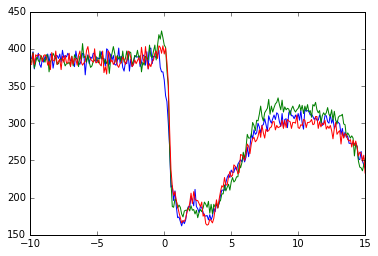

In [24]:
plt.plot(elist, iv1, elist, iv2, elist, iv3)

In [27]:
ivs1 = smooth(iv1, window_len=10, window_type='flat')
ivs2 = smooth(iv2, window_len=10, window_type='flat')
ivs3 = smooth(iv3, window_len=10, window_type='flat')

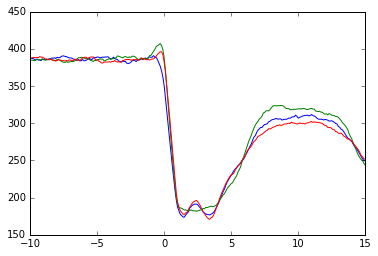

In [28]:
plt.plot(elist, ivs1, elist, ivs2, elist, ivs3)

The primary region of interest in Energy-space is the Low-Energy regime: 0-5eV.

In this region, clearly two of the three curves have the same basic shape (red, blue) whereas the other curve (green) does not.

The goal now is to come up with a method to differentiate between curves which are approximately flat(green) after smoothing, and those which are not (red, blue). Also, methods for counting the number of Extrema will be required for further analysis fo the curves.

From a graphical analysis, the red/blue curves have two pronounced minima, whereas the green curve has essentially just one minima and is roughly flat.

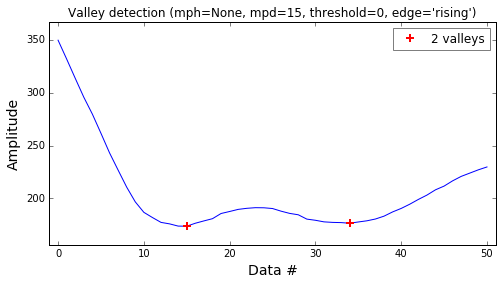

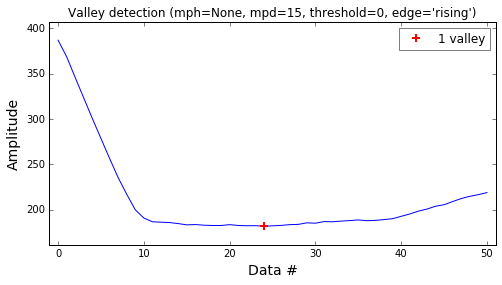

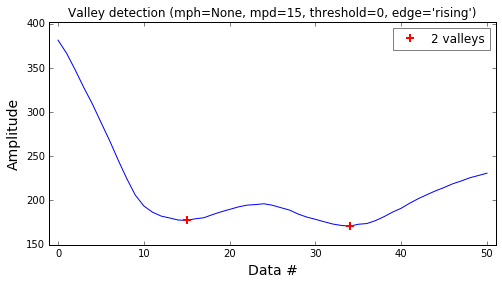

In [62]:
results = []
min_index = elist.index(0.0)
max_index = elist.index(5.1)
for iv in [ivs1[min_index:max_index], ivs2[min_index:max_index], ivs3[min_index:max_index]]:
    inds = dp(iv, valley=True, mpd=15, show=True)
    results.append(len(inds))
    # dpp(iv, valley=True)
    


This method works for clearly defined peaks but still struggles with curves that are roughly flat without come strict limitations on the minimum peak to peak distance.

In [83]:
def num_min(iv):
    return len(dp(iv, valley=True, mpd=15))

Calculate smoothed data

In [84]:
%timeit -n 1 -r 1 siv = np.apply_along_axis(smooth, 2, data, window_len=10)

1 loop, best of 1: 25.7 s per loop


Calculate num minima for every set of I(V) data: direct method using np.apply_along_axis

In [86]:
%timeit -n 1 -r 1 mask = np.apply_along_axis(num_min, 2, siv[:, :, min_index:max_index])  # map num_min
    

1 loop, best of 1: 46 s per loop


Calculate num minima using a numpy iterator with index tracking:

In [88]:
ts = time.time()
top_image = siv[:, :, min_index]  # top slice of data set at 0.0 eV
it = np.nditer(top_image, flags=['multi_index'])
mask = np.zeros((siv.shape[0], siv.shape[1]))
while not it.finished:
    r = it.multi_index[0]
    c = it.multi_index[1]
    mask[r, c] = num_min(siv[r, c, min_index:max_index])
    it.iternext()
print("Elapsed {}".format(time.time() - ts))



Elapsed 42.99432992935181


Using a numpy iterator is only marginally faster than simply calling np.apply_along_axis()
Thus, The only likely scenario for speeding up this calculation is finding a way to vectorize as much as possible. Other options would include using cython, numba, or a hand written function directly in C/C++/Fortran.

Easy way to visualize the results:

In [79]:
def discrete_imshow(data):
    """
    """
    cmap= cm.Spectral
    colors = cmap(np.linspace(0, 1, np.max(data) - np.min(data) + 1))
    cmap = clrs.ListedColormap(colors)
    img = plt.imshow(data, interpolation='none', cmap=cmap)
    plt.grid(False)
    ticks = np.arange(np.min(data), np.max(data) + 1)
    tickpos = np.linspace(ticks[0]+0.5, ticks[-1]-0.5, len(ticks))
    ax = plt.colorbar(img, ticks=tickpos)
    ax.set_ticklabels(ticks)
    plt.axis('off')
    plt.show()

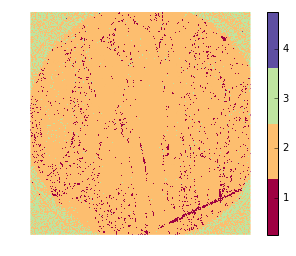

In [82]:
discrete_imshow(mask)